In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('bmh')

import tensorflow as tf
from tensorflow import keras
import inspect
from tqdm import tqdm
import pandas as pd

#### Load Images

In [2]:
X_train_full = np.load('data_train.npy').T
t_train_full = np.load('labels_train.npy')

X_train_full.shape, t_train_full.shape

((6195, 270000), (6195,))

In [3]:
from sklearn.model_selection import train_test_split

# Training and Test sets
X_training, X_test, t_training, t_test = train_test_split(X_train_full, t_train_full, shuffle=True, stratify=t_train_full, test_size=0.15)
# Train/Learn and validation sets
X_train, X_val, t_train, t_val = train_test_split(X_training, t_training, shuffle=True, stratify=t_training, test_size=0.2)

X_train = X_train.reshape((X_train.shape[0],300,300,3))
X_val = X_val.reshape((X_val.shape[0],300,300,3))
X_test = X_test.reshape((X_test.shape[0],300,300,3))

class_names = ['Stop',
               'Yield',
               'Red Light',
               'Green Light',
               'Roundabout',
               'Right Turn Only',
               'Do Not Enter',
               'Crosswalk',
               'Handicap Parking',
               'No Parking']

class_num = len(class_names)

X_train.shape, t_train.shape, X_val.shape, t_val.shape, class_num

((4212, 300, 300, 3), (4212,), (1053, 300, 300, 3), (1053,), 10)

In [4]:
batch_size = 32
num_iterations = int(X_train.shape[0] / batch_size)

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, t_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, t_val))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, t_test))

Metal device set to: Apple M1 Max

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB



2022-07-27 12:55:59.521438: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-07-27 12:55:59.521586: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [5]:
num_iterations

131

#### Get All Models

In [6]:
model_dictionary = {m[0]:m[1] for m in inspect.getmembers(tf.keras.applications, inspect.isfunction)}

#### Image Preprocessing - taken from: https://towardsdatascience.com/how-to-choose-the-best-keras-pre-trained-model-for-image-classification-b850ca4428d4

In [7]:
def normalize_img(image, label, img_size):
    # Resize image to the desired img_size and normalize it
    # One hot encode the label
    image = tf.image.resize(image, img_size)
    image = tf.cast(image, tf.float32) / 255.
    label = tf.cast(label, tf.uint8)
    label = tf.one_hot(label, depth=class_num)
    return image, label
    
def preprocess_data(train, validation, test, batch_size, img_size):
    # Apply the normalize_img function on all train and validation data and create batches
    train_processed = train.map(lambda image, label: normalize_img(image, label, img_size))
    
    # If your data is already batched (eg, when using the image_dataset_from_directory function), remove .batch(batch_size)
    train_processed = train_processed.batch(batch_size).repeat()
    
    validation_processed = validation.map(lambda image, label: normalize_img(image, label, img_size))
    
    # If your data is already batched (eg, when using the image_dataset_from_directory function), remove .batch(batch_size)
    validation_processed = validation_processed.batch(batch_size)
    
    test_processed = test.map(lambda image, label: normalize_img(image, label, img_size))
    
    # If your data is already batched (eg, when using the image_dataset_from_directory function), remove .batch(batch_size)
    test_processed = test_processed.batch(batch_size)
    
    return train_processed, validation_processed,test_processed
    
# Run preprocessing
train_processed_224, validation_processed_224, test_processed_224 = preprocess_data(train_dataset, val_dataset, test_dataset, batch_size, img_size=[224,224])
train_processed_331, validation_processed_331, test_processed_331 = preprocess_data(train_dataset, val_dataset, test_dataset, batch_size, img_size=[331,331])

#### Testing

In [8]:
# Loop over each model available in Keras
model_benchmarks = {'model_name': [], 'num_model_params': [], 'validation_accuracy': []}

for model_name, model in tqdm(model_dictionary.items()):
    # Special handling for "NASNetLarge" since it requires input images with size (331,331)
    if 'NASNetLarge' in model_name:
        input_shape=(331,331,3)
        train_processed = train_processed_331
        validation_processed = validation_processed_331
    else:
        input_shape=(224,224,3)
        train_processed = train_processed_224
        validation_processed = validation_processed_224
        
    # load the pre-trained model with global average pooling as the last layer and freeze the model weights
    pre_trained_model = model(include_top=False, pooling='avg', input_shape=input_shape)
    pre_trained_model.trainable = False
    
    # custom modifications on top of pre-trained model and fit
    clf_model = tf.keras.models.Sequential()
    clf_model.add(pre_trained_model)
    clf_model.add(tf.keras.layers.Dense(class_num, activation='softmax'))
    clf_model.compile(loss='categorical_crossentropy', metrics=['accuracy'])
    history = clf_model.fit(train_processed, epochs=3, validation_data=validation_processed, steps_per_epoch=num_iterations)
    
    # Calculate all relevant metrics
    model_benchmarks['model_name'].append(model_name)
    model_benchmarks['num_model_params'].append(pre_trained_model.count_params())
    model_benchmarks['validation_accuracy'].append(history.history['val_accuracy'][-1])

  0%|          | 0/28 [00:00<?, ?it/s]2022-07-27 12:56:28.605062: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/3


2022-07-27 12:56:30.026267: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


131/131 [==============================] - ETA: 0s - loss: 0.9920 - accuracy: 0.7261

2022-07-27 12:56:44.834625: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


131/131 [==============================] - 20s 118ms/step - loss: 0.9920 - accuracy: 0.7261 - val_loss: 0.4959 - val_accuracy: 0.8746
Epoch 2/3
131/131 [==============================] - 16s 111ms/step - loss: 0.3852 - accuracy: 0.9146 - val_loss: 0.3468 - val_accuracy: 0.9174
Epoch 3/3
131/131 [==============================] - 15s 117ms/step - loss: 0.2799 - accuracy: 0.9419 - val_loss: 0.2737 - val_accuracy: 0.9383


  4%|▎         | 1/28 [00:52<23:46, 52.83s/it]

51888128/51877672 [==============================] - 1s 0us/step
Epoch 1/3


2022-07-27 12:57:24.873952: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


131/131 [==============================] - ETA: 0s - loss: 0.8432 - accuracy: 0.7739

2022-07-27 12:57:40.523066: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


131/131 [==============================] - 23s 153ms/step - loss: 0.8432 - accuracy: 0.7739 - val_loss: 0.4131 - val_accuracy: 0.9136
Epoch 2/3
131/131 [==============================] - 20s 140ms/step - loss: 0.3142 - accuracy: 0.9325 - val_loss: 0.3080 - val_accuracy: 0.9259
Epoch 3/3
131/131 [==============================] - 19s 146ms/step - loss: 0.2267 - accuracy: 0.9526 - val_loss: 0.2394 - val_accuracy: 0.9468


  7%|▋         | 2/28 [01:57<25:57, 59.89s/it]

74850304/74836368 [==============================] - 1s 0us/step
Epoch 1/3


2022-07-27 12:58:31.607552: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


131/131 [==============================] - ETA: 0s - loss: 0.8516 - accuracy: 0.7722

2022-07-27 12:58:52.214146: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


131/131 [==============================] - 31s 202ms/step - loss: 0.8516 - accuracy: 0.7722 - val_loss: 0.4170 - val_accuracy: 0.9155
Epoch 2/3
131/131 [==============================] - 26s 180ms/step - loss: 0.3391 - accuracy: 0.9299 - val_loss: 0.2919 - val_accuracy: 0.9345
Epoch 3/3
131/131 [==============================] - 24s 186ms/step - loss: 0.2422 - accuracy: 0.9536 - val_loss: 0.2251 - val_accuracy: 0.9516


 11%|█         | 3/28 [03:22<29:44, 71.38s/it]

16719872/16705208 [==============================] - 0s 0us/step
Epoch 1/3


2022-07-27 12:59:53.185356: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


131/131 [==============================] - ETA: 0s - loss: 2.3164 - accuracy: 0.0997

2022-07-27 13:00:05.850063: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


131/131 [==============================] - 18s 89ms/step - loss: 2.3164 - accuracy: 0.0997 - val_loss: 2.3087 - val_accuracy: 0.0997
Epoch 2/3
131/131 [==============================] - 10s 75ms/step - loss: 2.3119 - accuracy: 0.1055 - val_loss: 2.3090 - val_accuracy: 0.0997
Epoch 3/3
131/131 [==============================] - 10s 80ms/step - loss: 2.3103 - accuracy: 0.1110 - val_loss: 2.3057 - val_accuracy: 0.0988


 14%|█▍        | 4/28 [04:03<23:40, 59.17s/it]

27033600/27018416 [==============================] - 1s 0us/step
Epoch 1/3


2022-07-27 13:00:35.522060: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


131/131 [==============================] - ETA: 0s - loss: 2.3226 - accuracy: 0.1088

2022-07-27 13:00:49.006875: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


131/131 [==============================] - 21s 125ms/step - loss: 2.3226 - accuracy: 0.1088 - val_loss: 2.3150 - val_accuracy: 0.0997
Epoch 2/3
131/131 [==============================] - 15s 107ms/step - loss: 2.3182 - accuracy: 0.1079 - val_loss: 2.3168 - val_accuracy: 0.0969
Epoch 3/3
131/131 [==============================] - 14s 111ms/step - loss: 2.3162 - accuracy: 0.1108 - val_loss: 2.3136 - val_accuracy: 0.0997


 18%|█▊        | 5/28 [04:56<21:55, 57.19s/it]

31801344/31790344 [==============================] - 1s 0us/step
Epoch 1/3


2022-07-27 13:01:28.420119: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


131/131 [==============================] - ETA: 0s - loss: 2.3281 - accuracy: 0.1042

2022-07-27 13:01:43.680233: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


131/131 [==============================] - 23s 138ms/step - loss: 2.3281 - accuracy: 0.1042 - val_loss: 2.3204 - val_accuracy: 0.0997
Epoch 2/3
131/131 [==============================] - 17s 116ms/step - loss: 2.3226 - accuracy: 0.1110 - val_loss: 2.3192 - val_accuracy: 0.1083
Epoch 3/3
131/131 [==============================] - 16s 121ms/step - loss: 2.3197 - accuracy: 0.1115 - val_loss: 2.3206 - val_accuracy: 0.0988


 21%|██▏       | 6/28 [05:54<21:03, 57.43s/it]

43950080/43941136 [==============================] - 1s 0us/step
Epoch 1/3


2022-07-27 13:02:28.031167: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


131/131 [==============================] - ETA: 0s - loss: 2.3382 - accuracy: 0.1000

2022-07-27 13:02:48.253926: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


131/131 [==============================] - 31s 190ms/step - loss: 2.3382 - accuracy: 0.1000 - val_loss: 2.3255 - val_accuracy: 0.0997
Epoch 2/3
131/131 [==============================] - 22s 153ms/step - loss: 2.3276 - accuracy: 0.1093 - val_loss: 2.3251 - val_accuracy: 0.1026
Epoch 3/3
131/131 [==============================] - 21s 160ms/step - loss: 2.3229 - accuracy: 0.1117 - val_loss: 2.3333 - val_accuracy: 0.0997


 25%|██▌       | 7/28 [07:12<22:23, 63.96s/it]

71696384/71686520 [==============================] - 1s 0us/step
Epoch 1/3


2022-07-27 13:03:46.498276: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


131/131 [==============================] - ETA: 0s - loss: 2.3452 - accuracy: 0.0992

2022-07-27 13:04:11.068682: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


131/131 [==============================] - 37s 240ms/step - loss: 2.3452 - accuracy: 0.0992 - val_loss: 2.3364 - val_accuracy: 0.0997
Epoch 2/3
131/131 [==============================] - 29s 206ms/step - loss: 2.3374 - accuracy: 0.1014 - val_loss: 2.3397 - val_accuracy: 0.0997
Epoch 3/3
131/131 [==============================] - 27s 204ms/step - loss: 2.3343 - accuracy: 0.1045 - val_loss: 2.3528 - val_accuracy: 0.0997


 29%|██▊       | 8/28 [08:49<24:50, 74.55s/it]

115277824/115263384 [==============================] - 2s 0us/step
Epoch 1/3


2022-07-27 13:05:25.357731: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


131/131 [==============================] - ETA: 0s - loss: 2.3172 - accuracy: 0.1276

2022-07-27 13:06:01.678705: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


131/131 [==============================] - 54s 342ms/step - loss: 2.3172 - accuracy: 0.1276 - val_loss: 2.2965 - val_accuracy: 0.0997
Epoch 2/3
131/131 [==============================] - 39s 280ms/step - loss: 2.2808 - accuracy: 0.1469 - val_loss: 2.2645 - val_accuracy: 0.1595
Epoch 3/3
131/131 [==============================] - 37s 286ms/step - loss: 2.2671 - accuracy: 0.1531 - val_loss: 2.2695 - val_accuracy: 0.1387


 32%|███▏      | 9/28 [11:05<29:39, 93.66s/it]

165249024/165234480 [==============================] - 3s 0us/step
Epoch 1/3


2022-07-27 13:07:42.441516: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


131/131 [==============================] - ETA: 0s - loss: 2.3326 - accuracy: 0.1100

2022-07-27 13:08:31.081786: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


131/131 [==============================] - 72s 460ms/step - loss: 2.3326 - accuracy: 0.1100 - val_loss: 2.2917 - val_accuracy: 0.1197
Epoch 2/3
131/131 [==============================] - 55s 396ms/step - loss: 2.3039 - accuracy: 0.1263 - val_loss: 2.2699 - val_accuracy: 0.1263
Epoch 3/3
131/131 [==============================] - 52s 395ms/step - loss: 2.2944 - accuracy: 0.1311 - val_loss: 2.2779 - val_accuracy: 0.1387


 36%|███▌      | 10/28 [14:09<36:27, 121.54s/it]

258088960/258076736 [==============================] - 5s 0us/step
Epoch 1/3


2022-07-27 13:10:51.458247: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


131/131 [==============================] - ETA: 0s - loss: 2.3709 - accuracy: 0.0945

2022-07-27 13:11:52.755828: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


131/131 [==============================] - 93s 599ms/step - loss: 2.3709 - accuracy: 0.0945 - val_loss: 2.3704 - val_accuracy: 0.0997
Epoch 2/3
131/131 [==============================] - 72s 506ms/step - loss: 2.3610 - accuracy: 0.0971 - val_loss: 2.3831 - val_accuracy: 0.0997
Epoch 3/3
131/131 [==============================] - 64s 487ms/step - loss: 2.3575 - accuracy: 0.1000 - val_loss: 2.3809 - val_accuracy: 0.0997


 39%|███▉      | 11/28 [18:08<44:38, 157.53s/it]

219070464/219055592 [==============================] - 4s 0us/step
Epoch 1/3


2022-07-27 13:14:45.492064: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


131/131 [==============================] - ETA: 0s - loss: 0.9336 - accuracy: 0.7137

2022-07-27 13:15:18.330825: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


131/131 [==============================] - 55s 336ms/step - loss: 0.9336 - accuracy: 0.7137 - val_loss: 0.6070 - val_accuracy: 0.8253
Epoch 2/3
131/131 [==============================] - 29s 182ms/step - loss: 0.5121 - accuracy: 0.8526 - val_loss: 0.5311 - val_accuracy: 0.8262
Epoch 3/3
131/131 [==============================] - 25s 191ms/step - loss: 0.4067 - accuracy: 0.8888 - val_loss: 0.3947 - val_accuracy: 0.8870


 43%|████▎     | 12/28 [20:04<38:42, 145.14s/it]

87924736/87910968 [==============================] - 2s 0us/step
Epoch 1/3


2022-07-27 13:16:36.317053: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


131/131 [==============================] - ETA: 0s - loss: 0.6907 - accuracy: 0.7894

2022-07-27 13:16:48.368915: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


131/131 [==============================] - 20s 127ms/step - loss: 0.6907 - accuracy: 0.7894 - val_loss: 0.3570 - val_accuracy: 0.9012
Epoch 2/3
131/131 [==============================] - 12s 79ms/step - loss: 0.3190 - accuracy: 0.9153 - val_loss: 0.4243 - val_accuracy: 0.8661
Epoch 3/3
131/131 [==============================] - 11s 80ms/step - loss: 0.2426 - accuracy: 0.9411 - val_loss: 0.2544 - val_accuracy: 0.9316


 46%|████▋     | 13/28 [20:51<28:50, 115.35s/it]

17235968/17225924 [==============================] - 0s 0us/step
Epoch 1/3


2022-07-27 13:17:20.144974: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


130/131 [============================>.] - ETA: 0s - loss: 0.6772 - accuracy: 0.8031

2022-07-27 13:17:25.906937: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


131/131 [==============================] - 9s 56ms/step - loss: 0.6738 - accuracy: 0.8042 - val_loss: 0.3213 - val_accuracy: 0.9183
Epoch 2/3
131/131 [==============================] - 6s 41ms/step - loss: 0.2840 - accuracy: 0.9289 - val_loss: 0.2598 - val_accuracy: 0.9316
Epoch 3/3
131/131 [==============================] - 6s 45ms/step - loss: 0.2080 - accuracy: 0.9533 - val_loss: 0.2076 - val_accuracy: 0.9468


 50%|█████     | 14/28 [21:13<20:18, 87.03s/it] 

9420800/9406464 [==============================] - 0s 0us/step
Epoch 1/3


2022-07-27 13:17:42.218164: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


130/131 [============================>.] - ETA: 0s - loss: 0.7131 - accuracy: 0.7851

2022-07-27 13:17:49.911703: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


131/131 [==============================] - 12s 75ms/step - loss: 0.7095 - accuracy: 0.7860 - val_loss: 0.4214 - val_accuracy: 0.8794
Epoch 2/3
131/131 [==============================] - 7s 49ms/step - loss: 0.3215 - accuracy: 0.9177 - val_loss: 0.3459 - val_accuracy: 0.9022
Epoch 3/3
131/131 [==============================] - 7s 52ms/step - loss: 0.2402 - accuracy: 0.9419 - val_loss: 0.2855 - val_accuracy: 0.9269


 54%|█████▎    | 15/28 [21:41<15:00, 69.25s/it]

17620992/17605208 [==============================] - 0s 0us/step
Epoch 1/3


2022-07-27 13:18:11.066134: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


130/131 [============================>.] - ETA: 0s - loss: 2.2155 - accuracy: 0.1731

2022-07-27 13:18:21.677853: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


131/131 [==============================] - 17s 96ms/step - loss: 2.2144 - accuracy: 0.1734 - val_loss: 2.1062 - val_accuracy: 0.1994
Epoch 2/3
131/131 [==============================] - 8s 52ms/step - loss: 2.0706 - accuracy: 0.2426 - val_loss: 2.0371 - val_accuracy: 0.2631
Epoch 3/3
131/131 [==============================] - 7s 52ms/step - loss: 1.9947 - accuracy: 0.2775 - val_loss: 1.9998 - val_accuracy: 0.2887


 57%|█████▋    | 16/28 [22:14<11:41, 58.49s/it]

6709248/6698480 [==============================] - 0s 0us/step
Epoch 1/3


2022-07-27 13:18:46.935246: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


131/131 [==============================] - ETA: 0s - loss: 2.2702 - accuracy: 0.1512

2022-07-27 13:18:55.787981: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


131/131 [==============================] - 18s 85ms/step - loss: 2.2702 - accuracy: 0.1512 - val_loss: 2.2147 - val_accuracy: 0.1795
Epoch 2/3
131/131 [==============================] - 7s 46ms/step - loss: 2.1796 - accuracy: 0.2146 - val_loss: 2.1467 - val_accuracy: 0.2061
Epoch 3/3
131/131 [==============================] - 6s 43ms/step - loss: 2.1207 - accuracy: 0.2488 - val_loss: 2.1103 - val_accuracy: 0.2184


 61%|██████    | 17/28 [22:46<09:15, 50.53s/it]

343621632/343610240 [==============================] - 6s 0us/step
Epoch 1/3


2022-07-27 13:19:28.177356: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


131/131 [==============================] - ETA: 0s - loss: 1.1551 - accuracy: 0.6753

2022-07-27 13:21:54.228905: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


131/131 [==============================] - 201s 1s/step - loss: 1.1551 - accuracy: 0.6753 - val_loss: 0.7827 - val_accuracy: 0.8063
Epoch 2/3
131/131 [==============================] - 174s 1s/step - loss: 0.6403 - accuracy: 0.8263 - val_loss: 0.6040 - val_accuracy: 0.8395
Epoch 3/3
131/131 [==============================] - 171s 1s/step - loss: 0.4898 - accuracy: 0.8691 - val_loss: 0.5179 - val_accuracy: 0.8481


 64%|██████▍   | 18/28 [32:02<33:41, 202.17s/it]

20004864/19993432 [==============================] - 0s 0us/step
Epoch 1/3


2022-07-27 13:28:36.259711: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


131/131 [==============================] - ETA: 0s - loss: 1.2094 - accuracy: 0.6348

2022-07-27 13:28:56.412224: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


131/131 [==============================] - 42s 270ms/step - loss: 1.2094 - accuracy: 0.6348 - val_loss: 0.8022 - val_accuracy: 0.7854
Epoch 2/3
131/131 [==============================] - 22s 123ms/step - loss: 0.6480 - accuracy: 0.8282 - val_loss: 0.6030 - val_accuracy: 0.8243
Epoch 3/3
131/131 [==============================] - 15s 114ms/step - loss: 0.5008 - accuracy: 0.8667 - val_loss: 0.5133 - val_accuracy: 0.8490


 68%|██████▊   | 19/28 [33:24<24:56, 166.33s/it]

171458560/171446536 [==============================] - 3s 0us/step
Epoch 1/3


2022-07-27 13:29:59.262825: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


131/131 [==============================] - ETA: 0s - loss: 2.1037 - accuracy: 0.2865

2022-07-27 13:30:25.987709: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


131/131 [==============================] - 41s 279ms/step - loss: 2.1037 - accuracy: 0.2865 - val_loss: 1.9451 - val_accuracy: 0.3875
Epoch 2/3
131/131 [==============================] - 30s 209ms/step - loss: 1.8197 - accuracy: 0.4440 - val_loss: 1.7542 - val_accuracy: 0.4786
Epoch 3/3
131/131 [==============================] - 29s 219ms/step - loss: 1.6574 - accuracy: 0.5110 - val_loss: 1.6332 - val_accuracy: 0.4777


 71%|███████▏  | 20/28 [35:10<19:45, 148.14s/it]

171327488/171317808 [==============================] - 3s 0us/step
Epoch 1/3


2022-07-27 13:31:44.757090: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


131/131 [==============================] - ETA: 0s - loss: 0.6544 - accuracy: 0.8182

2022-07-27 13:32:10.750545: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


131/131 [==============================] - 40s 257ms/step - loss: 0.6544 - accuracy: 0.8182 - val_loss: 0.3487 - val_accuracy: 0.9155
Epoch 2/3
131/131 [==============================] - 28s 195ms/step - loss: 0.2894 - accuracy: 0.9321 - val_loss: 0.2803 - val_accuracy: 0.9345
Epoch 3/3
131/131 [==============================] - 26s 199ms/step - loss: 0.2145 - accuracy: 0.9490 - val_loss: 0.2429 - val_accuracy: 0.9392


 75%|███████▌  | 21/28 [36:49<15:33, 133.38s/it]

234708992/234698864 [==============================] - 4s 0us/step
Epoch 1/3


2022-07-27 13:33:24.466271: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


131/131 [==============================] - ETA: 0s - loss: 2.0833 - accuracy: 0.2867

2022-07-27 13:34:06.628054: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


131/131 [==============================] - 63s 406ms/step - loss: 2.0833 - accuracy: 0.2867 - val_loss: 1.9201 - val_accuracy: 0.3647
Epoch 2/3
131/131 [==============================] - 43s 298ms/step - loss: 1.8014 - accuracy: 0.4273 - val_loss: 1.7336 - val_accuracy: 0.4919
Epoch 3/3
131/131 [==============================] - 40s 305ms/step - loss: 1.6472 - accuracy: 0.4797 - val_loss: 1.6178 - val_accuracy: 0.4796


 79%|███████▊  | 22/28 [39:21<13:53, 138.96s/it]

234561536/234545216 [==============================] - 4s 0us/step
Epoch 1/3


2022-07-27 13:35:57.089674: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


131/131 [==============================] - ETA: 0s - loss: 0.6832 - accuracy: 0.8061

2022-07-27 13:36:34.013475: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


131/131 [==============================] - 59s 394ms/step - loss: 0.6832 - accuracy: 0.8061 - val_loss: 0.3854 - val_accuracy: 0.9003
Epoch 2/3
131/131 [==============================] - 41s 283ms/step - loss: 0.3058 - accuracy: 0.9256 - val_loss: 0.3269 - val_accuracy: 0.9088
Epoch 3/3
131/131 [==============================] - 38s 291ms/step - loss: 0.2317 - accuracy: 0.9462 - val_loss: 0.2645 - val_accuracy: 0.9383


 82%|████████▏ | 23/28 [41:45<11:42, 140.52s/it]

94781440/94765736 [==============================] - 2s 0us/step
Epoch 1/3


2022-07-27 13:38:17.823932: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


131/131 [==============================] - ETA: 0s - loss: 2.1093 - accuracy: 0.2770

2022-07-27 13:38:33.758977: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


131/131 [==============================] - 24s 159ms/step - loss: 2.1093 - accuracy: 0.2770 - val_loss: 1.9433 - val_accuracy: 0.3789
Epoch 2/3
131/131 [==============================] - 19s 125ms/step - loss: 1.8356 - accuracy: 0.4196 - val_loss: 1.7559 - val_accuracy: 0.4748
Epoch 3/3
131/131 [==============================] - 17s 129ms/step - loss: 1.6838 - accuracy: 0.4732 - val_loss: 1.6519 - val_accuracy: 0.4663


 86%|████████▌ | 24/28 [42:49<07:49, 117.45s/it]

94683136/94668760 [==============================] - 2s 0us/step
Epoch 1/3


2022-07-27 13:39:19.750766: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


131/131 [==============================] - ETA: 0s - loss: 0.6725 - accuracy: 0.8163

2022-07-27 13:39:34.746715: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


131/131 [==============================] - 22s 142ms/step - loss: 0.6725 - accuracy: 0.8163 - val_loss: 0.3529 - val_accuracy: 0.9136
Epoch 2/3
131/131 [==============================] - 15s 107ms/step - loss: 0.2870 - accuracy: 0.9349 - val_loss: 0.2809 - val_accuracy: 0.9297
Epoch 3/3
131/131 [==============================] - 15s 116ms/step - loss: 0.2168 - accuracy: 0.9522 - val_loss: 0.2325 - val_accuracy: 0.9440


 89%|████████▉ | 25/28 [43:44<04:55, 98.66s/it] 

58900480/58889256 [==============================] - 1s 0us/step
Epoch 1/3


2022-07-27 13:40:12.947051: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


131/131 [==============================] - ETA: 0s - loss: 1.8135 - accuracy: 0.5592

2022-07-27 13:40:36.756872: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


131/131 [==============================] - 31s 226ms/step - loss: 1.8135 - accuracy: 0.5592 - val_loss: 1.4431 - val_accuracy: 0.7559
Epoch 2/3
131/131 [==============================] - 29s 220ms/step - loss: 1.1984 - accuracy: 0.7830 - val_loss: 1.0363 - val_accuracy: 0.7996
Epoch 3/3
131/131 [==============================] - 29s 222ms/step - loss: 0.8928 - accuracy: 0.8246 - val_loss: 0.8260 - val_accuracy: 0.8281


 93%|█████████▎| 26/28 [45:14<03:12, 96.26s/it]

80150528/80134624 [==============================] - 1s 0us/step
Epoch 1/3


2022-07-27 13:41:44.041815: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


131/131 [==============================] - ETA: 0s - loss: 1.9054 - accuracy: 0.5203

2022-07-27 13:42:12.368689: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


131/131 [==============================] - 36s 275ms/step - loss: 1.9054 - accuracy: 0.5203 - val_loss: 1.5596 - val_accuracy: 0.7047
Epoch 2/3
131/131 [==============================] - 35s 268ms/step - loss: 1.3267 - accuracy: 0.7584 - val_loss: 1.1543 - val_accuracy: 0.7854
Epoch 3/3
131/131 [==============================] - 35s 271ms/step - loss: 1.0120 - accuracy: 0.8043 - val_loss: 0.9275 - val_accuracy: 0.8091


 96%|█████████▋| 27/28 [47:04<01:40, 100.20s/it]

Epoch 1/3


2022-07-27 13:43:32.906457: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


131/131 [==============================] - ETA: 0s - loss: 0.8429 - accuracy: 0.7712

2022-07-27 13:43:57.887070: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


131/131 [==============================] - 32s 236ms/step - loss: 0.8429 - accuracy: 0.7712 - val_loss: 0.5227 - val_accuracy: 0.8642
Epoch 2/3
131/131 [==============================] - 28s 209ms/step - loss: 0.4234 - accuracy: 0.8902 - val_loss: 0.4122 - val_accuracy: 0.8917
Epoch 3/3
131/131 [==============================] - 28s 214ms/step - loss: 0.3284 - accuracy: 0.9165 - val_loss: 0.3646 - val_accuracy: 0.9022


100%|██████████| 28/28 [48:33<00:00, 104.06s/it]


#### Check Accuracy

In [9]:
# Convert Results to DataFrame for easy viewing
benchmark_df = pd.DataFrame(model_benchmarks)

# sort in ascending order of num_model_params column
benchmark_df.sort_values('num_model_params', inplace=True)

# write results to csv file
benchmark_df.to_csv('benchmark_df.csv', index=False)
benchmark_df

,model_name,num_model_params,validation_accuracy
16,MobileNetV3Small,1529968,0.218424
14,MobileNetV2,2257984,0.926876
13,MobileNet,3228864,0.946819
3,EfficientNetB0,4049571,0.098765
15,MobileNetV3Large,4226432,0.288699
18,NASNetMobile,4269716,0.849003
4,EfficientNetB1,6575239,0.099715
0,DenseNet121,7037504,0.938272
5,EfficientNetB2,7768569,0.098765
6,EfficientNetB3,10783535,0.099715


#### Plot

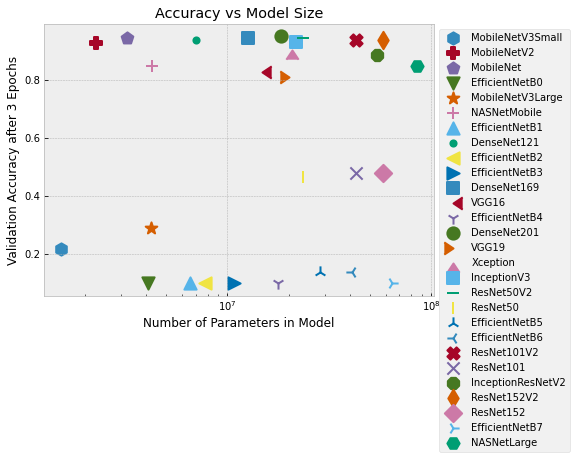

In [10]:

# Loop over each row and plot the num_model_params vs validation_accuracy
markers=[".",",","o","v","^","<",">","1","2","3","4","8","s","p","P","*","h","H","+","x","X","D","d","|","_",4,5,6,7,8,9,10,11]
plt.figure(figsize=(7,5))

for row in benchmark_df.itertuples():
    plt.scatter(row.num_model_params, row.validation_accuracy, label=row.model_name, marker=markers[row.Index], s=150, linewidths=2)
    
plt.xscale('log')
plt.xlabel('Number of Parameters in Model')
plt.ylabel('Validation Accuracy after 3 Epochs')
plt.title('Accuracy vs Model Size')

# Move legend out of the plot
plt.legend(bbox_to_anchor=(1, 1), loc='upper left');